Code Inspired from [Tensorflow Tutorials](https://www.tensorflow.org/tutorials/keras/text_classification)

# Text Classification


We train a Bidirectional LSTM (Deep Neural Network) classifier to perform Binary Sentiment analysis on an IMDB dataset to classify movie reviews as positive (1) or negative (0), based on the text of the review.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses
print(tf.__version__)

2.15.0


#### Download Dataset from URL

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')


84125825/84125825 [==============================] - 4s 0us/step


In [3]:
# Print an example text file
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


#### Prepare the Dataset

In [4]:
# CONFIG_FILE
BATCH_SIZE = 64
SEED = 0
MAX_FEATURES = 10000
SEQUENCE_LENGTH = 400
EMBEDDING_DIMENSION = 128
EPOCH = 100

In [5]:
# Remove unwanted directory from downloaded files
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [6]:
# Train Data
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
# Print an example Text and its corresponding label
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Example Review Text: \n", text_batch.numpy()[i])
    print("Example Label Text: \n", label_batch.numpy()[i])

# Print Label Values
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Example Review Text: 
 b"Violence whether real or not always has an impact. In this film the violence is about as crass as you could ask for. In the Great Ecstacy the director has successfully demonstrated what extremes of violence people are capable of. But what was the point? The violence looks like a mix of No\xc3\xab's 'Irreversible, and ' Kubrick's 'Clockwork Orange'...both of which are remarkable films. Don't get me wrong, I'm not opposed to screen violence at all and I've seen some nasty stuff in my film-going years, but this film as a whole is totally juvenile. The story is never developed enough to offer any reason for the extreme violence, the rizla paper thin reason we are give for Robert's demise is his introduction to drugs. Danny Dyer plays the character who is partly responsible for Robert's drug fuelled demise, however he is on screen for less than 5 minutes. Lesley Manville is Robert's unable to cope mum, I am not sure what either of these actors is doing in a film of 

In [8]:
# Validation Data
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
# Test Data
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.


### Data Preprocessing

Standardize, Tokenize, and Vectorize the dataset <br>
- Standardization refers to preprocessing the text
- Tokenization refers to splitting strings into tokens
- Vectorization refers to converting tokens into numbers

In [10]:
#  custom standardization function to remove the HTML tags
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

#### Vectorization Layer

In [11]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

In [12]:
# Make a text-only dataset (without labels)
train_text = raw_train_ds.map(lambda x, y: x)

# Call adapt to fit the state of the preprocessing layer to the dataset.
# This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of first review and label) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'This early role for Barbara Shelley(in fact,her first in Britain after working in Italy),was made when she was 24 years old,and it\'s certainly safe to say that she made a stunning debut in 1957\'s "Cat Girl." While blondes and brunettes get most of the attention(I\'ll always cherish Yutte Stensgaard),the lovely auburn-haired actress with the deep voice always exuded intelligence as well as vulnerability(one such example being 1960\'s "Village of the Damned," in which her screen time was much less than her character\'s husband,George Sanders).She is the sole reason for seeing this drab update of "Cat People," and is seen to great advantage throughout(it\'s difficult to say if her beauty found an even better showcase).Her character apparently sleeps in the nude,and we are exposed to her luscious bare back when she is awakened(also exposed 8 years later in 1965\'s "Rasputin-The Mad Monk").The ravishing gown she wears during most of the film is a stunning strapless wond

In [15]:
# See examples of Vectors and their corresponding vocabulary word values
print("2418 ---> ",vectorize_layer.get_vocabulary()[2418])
print(" 222 ---> ",vectorize_layer.get_vocabulary()[222])
print(" 51 ---> ",vectorize_layer.get_vocabulary()[51])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2418 --->  mere
 222 --->  done
 51 --->  more
Vocabulary size: 10000


In [16]:
# Vectorize the Train, Validation and Test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#### Configure the dataset for performance
`.cache()` keeps data in memory after it's loaded off disk.
`.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the ML Model

Description: <br>
1. `Embedding layer` - takes the integer-encoded reviews and looks up an embedding vector for each word-index. The resulting dimensions are: `(batch, sequence, embedding)`. <br> More: [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings)
2. `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example (Variable length) by averaging over the sequence dimension.
3. Densely connected with a single output node

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(MAX_FEATURES, EMBEDDING_DIMENSION),
  # layers.Dropout(0.3),
  # layers.Dense(1024, activation='relu'),
  layers.Bidirectional(layers.LSTM(EMBEDDING_DIMENSION,return_sequences=True, dropout=0.3)),
  # layers.Dropout(0.3),
  # layers.Dense(512, activation='relu'),
  layers.Bidirectional(layers.LSTM(int(EMBEDDING_DIMENSION/2), dropout=0.3)),
  # layers.Dropout(0.3),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(64, activation='relu'),
  # layers.GlobalAveragePooling1D(),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [25]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss = losses.BinaryCrossentropy()
metric = tf.metrics.BinaryAccuracy(threshold=0.5)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[metric]
              )

### Train the Model

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks = [callback]
    )

Epoch 1/100
313/313 [==============================] - 267s 833ms/step - loss: 0.5285 - binary_accuracy: 0.7307 - val_loss: 0.5778 - val_binary_accuracy: 0.6842
Epoch 2/100
313/313 [==============================] - 259s 829ms/step - loss: 0.3786 - binary_accuracy: 0.8460 - val_loss: 0.4493 - val_binary_accuracy: 0.8248
Epoch 3/100
313/313 [==============================] - 257s 821ms/step - loss: 0.2990 - binary_accuracy: 0.8865 - val_loss: 0.4014 - val_binary_accuracy: 0.8404
Epoch 4/100
313/313 [==============================] - 258s 824ms/step - loss: 0.2441 - binary_accuracy: 0.9101 - val_loss: 0.4076 - val_binary_accuracy: 0.8528
Epoch 5/100
313/313 [==============================] - 257s 822ms/step - loss: 0.1882 - binary_accuracy: 0.9370 - val_loss: 0.5027 - val_binary_accuracy: 0.8284
Epoch 6/100
313/313 [==============================] - 258s 824ms/step - loss: 0.1743 - binary_accuracy: 0.9380 - val_loss: 0.6040 - val_binary_accuracy: 0.8242
Epoch 7/100
313/313 [=============

### Evaluate the Model

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 [==============================] - 77s 197ms/step - loss: 0.4766 - binary_accuracy: 0.8102
Loss:  0.47664809226989746
Accuracy:  0.8102399706840515


### Create plots of Accuracy and Loss

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

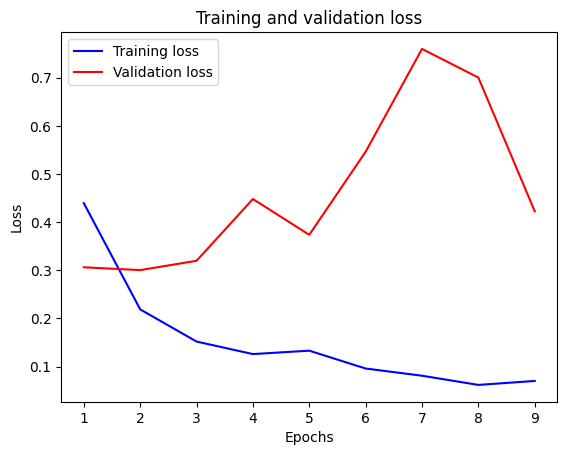

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

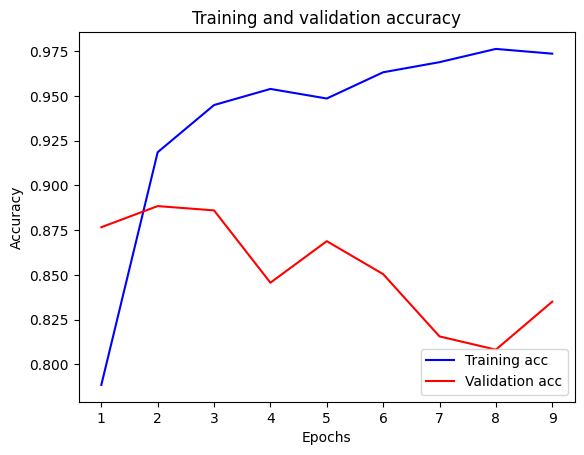

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()